<a href="https://colab.research.google.com/github/mansi2392/ImageClassification/blob/master/ResNetImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [136]:
%load_ext watermark
%watermark -a 'Mansi Kataria' -v -p torch



The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Author: Mansi Kataria

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 5.5.0

torch: 1.9.0+cu102



In [1]:
print("Note: code reference from: ")
print("https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html")

Note: code reference from: 
https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html


Imports

In [7]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks')

from helper_dataloaders import get_dataloaders_cifar10, UnNormalize
# from helper_plotting import imageshow
# from image_helper import imageshow

In [8]:
##########################
### SETTINGS
##########################

RANDOM_SEED = 123
BATCH_SIZE = 256
NUM_EPOCHS = 50
DEVICE = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

In [11]:
import random

def set_all_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
set_all_seeds(RANDOM_SEED)

In [12]:
##########################
### CIFAR-10 DATASET
##########################


train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((120, 120)),
    torchvision.transforms.RandomCrop((110, 110)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                      ])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((120, 120)),        
    torchvision.transforms.CenterCrop((110, 110)),            
    torchvision.transforms.ToTensor(),                
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


Plot a few examples from training dataset just for fun:
Reducing the batch size here to see some samples clearly



Extracting data/cifar-10-python.tar.gz to data


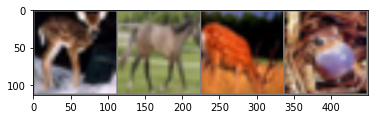

 deer horse  deer  frog


In [13]:
train_loader, valid_loader, test_loader = get_dataloaders_cifar10(
    batch_size=4,
    validation_fraction=0.1,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [14]:
#Getting DataLoaders with original batch size

train_loader, valid_loader, test_loader = get_dataloaders_cifar10(
    batch_size=BATCH_SIZE,
    validation_fraction=0.1,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    num_workers=2)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Files already downloaded and verified
Image batch dimensions: torch.Size([256, 3, 110, 110])
Image label dimensions: torch.Size([256])
Class labels of 10 examples: tensor([9, 7, 0, 5, 6, 9, 1, 7, 4, 5])


Let's now train a resnet model on the data


In [15]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [16]:
import torchvision.models as models
import torch.nn as nn

def initialize_model(num_classes, feature_extract, use_pretrained=False):
    model_ft = models.resnet18(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    input_size = 110
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(num_classes=10, feature_extract=True, use_pretrained=False)

# Print the model we just instantiated
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # inputs = inputs.to(DEVICE)
                # labels = labels.to(DEVICE)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [19]:
import torch.optim as optim

# Send the model to GPU
# model_ft = model_ft.to(DEVICE)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
feature_extract=True
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 fc.weight
	 fc.bias


In [23]:
import time
import copy
#Create data dictionary
dataloaders_dict = {'train': train_loader, 'val': valid_loader}

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=10, is_inception=False)

Epoch 0/9
----------
train Loss: 1.9423 Acc: 0.1902
val Loss: 0.2143 Acc: 0.0217

Epoch 1/9
----------
train Loss: 1.9029 Acc: 0.2128
val Loss: 0.2102 Acc: 0.0252

Epoch 2/9
----------
train Loss: 1.8711 Acc: 0.2282
val Loss: 0.2073 Acc: 0.0258

Epoch 3/9
----------
train Loss: 1.8472 Acc: 0.2380
val Loss: 0.2050 Acc: 0.0275

Epoch 4/9
----------
train Loss: 1.8273 Acc: 0.2463
val Loss: 0.2026 Acc: 0.0284

Epoch 5/9
----------
train Loss: 1.8094 Acc: 0.2544
val Loss: 0.2009 Acc: 0.0283

Epoch 6/9
----------
train Loss: 1.7960 Acc: 0.2599
val Loss: 0.1992 Acc: 0.0300

Epoch 7/9
----------
train Loss: 1.7819 Acc: 0.2650
val Loss: 0.1977 Acc: 0.0306

Epoch 8/9
----------


KeyboardInterrupt: ignored